# Imports

In [63]:
import os
import json
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
import numpy as np

import mlflow
import mlflow.pytorch
import torch
import torch.nn as nn
import pytorch_lightning as pl
from collections import defaultdict, OrderedDict
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights, resnet18
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor, BatchSizeFinder, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [6]:
IMAGES_DIR = os.path.join(os.getcwd(), '..', 'data', 'raw')
IMAGES_DIR

'/home/alumno/Desktop/datos/MLOps/MLOps-Lab3/notebooks/../data/raw'

In [10]:
os.listdir(IMAGES_DIR)[:10]

['leonberger_135.jpg',
 'Birman_56.jpg',
 'miniature_pinscher_169.jpg',
 'Birman_71.jpg',
 'British_Shorthair_89.jpg',
 'beagle_77.jpg',
 'staffordshire_bull_terrier_196.jpg',
 'german_shorthaired_55.jpg',
 'pug_16.jpg',
 'chihuahua_55.jpg']

# Dataset

In [12]:
class PetDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        # Get all image filenames
        image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
        
        # Extract class names and create DataFrame
        data = []
        for img_file in image_files:
            # Remove .jpg extension and split by underscore
            name_parts = img_file.replace('.jpg', '').split('_')
            # Class name is everything except the last part (image ID)
            class_name = '_'.join(name_parts[:-1])
            data.append({'image_name': img_file, 'class_name': class_name})
        
        self.df = pd.DataFrame(data)
        
        # Create label encoding (map class names to integers)
        unique_classes = sorted(self.df['class_name'].unique())
        self.class_to_idx = {cls: idx for idx, cls in enumerate(unique_classes)}
        self.df['label'] = self.df['class_name'].map(self.class_to_idx)
        
        self.images_dir = images_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        img_name = row['image_name']
        label = row['label']
        
        # Load img
        img_path = os.path.join(self.images_dir, f'{img_name}')
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [13]:
dataset = PetDataset(IMAGES_DIR)

In [14]:
dataset.class_to_idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

# Class distribution

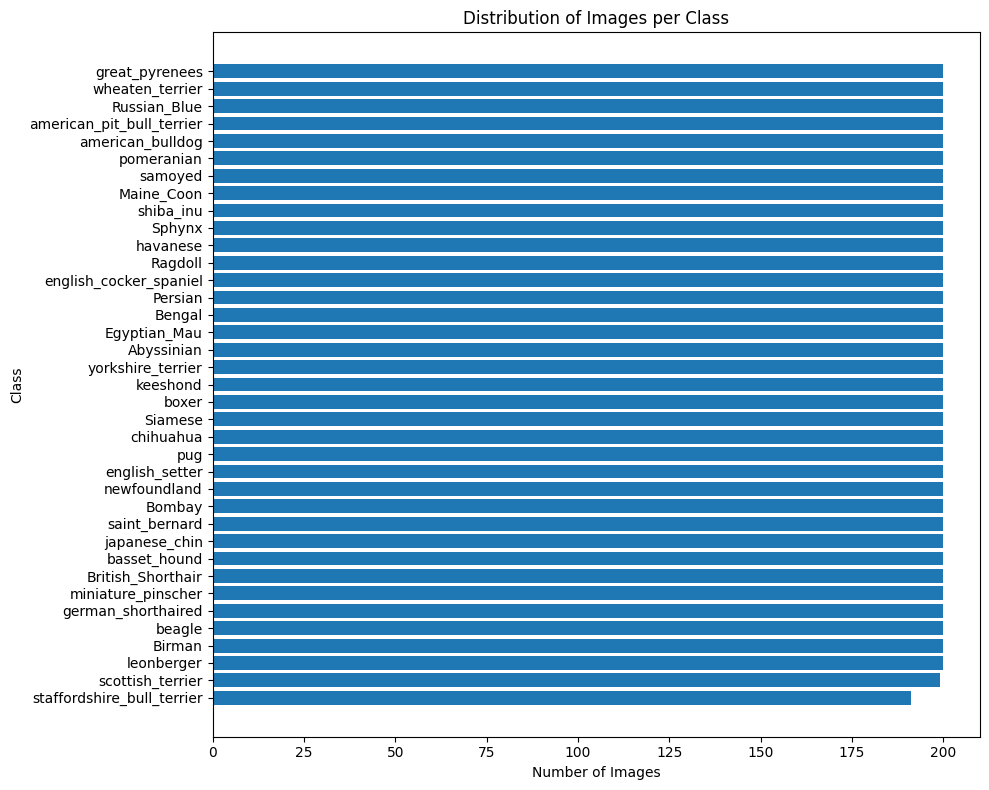

In [17]:
# Get class counts
class_counts = dataset.df['class_name'].value_counts().sort_values()

# Create horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(class_counts)), class_counts.values)
plt.yticks(range(len(class_counts)), class_counts.index)
plt.xlabel('Number of Images')
plt.ylabel('Class')
plt.title('Distribution of Images per Class')
plt.tight_layout()
plt.show()

# Toy Training MobileNet_v2

## DataModule

In [39]:
class DataModule(pl.LightningDataModule):
    def __init__(self, images_dir, batch_size=64, num_workers=2,
                 transform=MobileNet_V2_Weights.IMAGENET1K_V1.transforms(),
                 train_val_split=0.8, val_test_split=0.5):
        super().__init__()
        self.images_dir = images_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform
        self.train_val_split = train_val_split
        self.val_test_split = val_test_split
        
    def setup(self, stage=None):
        # Create full dataset
        full_dataset = PetDataset(self.images_dir, transform=self.transform)
        
        # Calculate split sizes
        total_size = len(full_dataset)
        train_size = int(total_size * self.train_val_split)
        remaining_size = total_size - train_size
        val_size = int(remaining_size * self.val_test_split)
        test_size = remaining_size - val_size
        
        # Split dataset
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, 
            [train_size, val_size, test_size]
        )
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            persistent_workers=True if self.num_workers > 0 else False
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            persistent_workers=True if self.num_workers > 0 else False
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            persistent_workers=True if self.num_workers > 0 else False
        )

## LightingModule

In [78]:
class LightningModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3, wd=0.):
        super().__init__()
        self.model = model
        self.lr = lr
        self.wd = wd

        self.training_step_outputs = defaultdict(float)
        self.validation_step_outputs = defaultdict(float)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        
        # Configure ReduceLROnPlateau scheduler
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',           # Minimize the monitored metric
            factor=0.1,          # Multiply LR by this factor when reducing
            patience=5,          # Number of epochs with no improvement before reducing LR
            threshold=0.01,      # Threshold for measuring improvement
            threshold_mode='rel', # 'rel' for relative change, 'abs' for absolute
            cooldown=0,          # Number of epochs to wait before resuming normal operation
            min_lr=1e-6,         # Lower bound on the learning rate
            eps=1e-8             # Minimal decay applied to lr
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',  # Metric to monitor
                'interval': 'epoch',     # Update scheduler after each epoch
                'frequency': 1,          # Check metric every epoch
                'strict': True,          # Enforce that monitored metric exists
            }
        }

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        # Log metrics
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
                
        self.training_step_outputs['loss'] += loss.detach().cpu()
        self.training_step_outputs['acc'] += acc.detach().cpu()
        self.training_step_outputs['steps'] += 1
            
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        # Log metrics
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True)

        self.validation_step_outputs['loss'] += loss.detach().cpu()
        self.validation_step_outputs['acc'] += acc.detach().cpu()
        self.validation_step_outputs['steps'] += 1
        
        return loss

    def on_train_epoch_end(self): 
        avg_loss = self.training_step_outputs['loss'] / self.training_step_outputs['steps']
        print(f"Average training loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.training_step_outputs.clear() 

    def on_validation_epoch_end(self):
        avg_loss = self.validation_step_outputs['loss'] / self.validation_step_outputs['steps']
        print(f"Average validation loss for epoch {self.current_epoch}: {avg_loss.item():.4f}")
        self.validation_step_outputs.clear()

## Training Loop

### MLFlow Experiment Setup

In [79]:
EXPERIMENT_NAME = "pet_classification_experiments"
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='/home/alumno/Desktop/datos/MLOps/MLOps-Lab3/notebooks/mlruns/1', creation_time=1765189303312, experiment_id='1', last_update_time=1765189303312, lifecycle_stage='active', name='pet_classification_experiments', tags={'mlflow.experimentKind': 'custom_model_development'}>

### MLFlow run setup

In [80]:
# Configuration for this run
config = {
    "model_name": "mobilenet_v2",
    "batch_size": 32,
    "learning_rate": 1e-3,
    "max_epochs": 3,
    "num_workers": 2,
    "train_val_split": 0.8,
    "val_test_split": 0.5,
    "optimizer": "Adam",
    "seed": 42,
    "dataset": "PetDataset",
    "weights": "IMAGENET1K_V1",
    "frozen_backbone": True
}
run_name = (
    f"toy_{config['model_name']}_"
    f"bs{config['batch_size']}_"
    f"lr{config['learning_rate']}_"
    f"ep{config['max_epochs']}_"
    f"tr{config['train_val_split']}_"
    f"fb{config['frozen_backbone']}"
)

In [81]:
NUM_CLASSES = len(dataset.class_to_idx)
NUM_CLASSES

37

In [82]:
# Start MLflow run
with mlflow.start_run(run_name=run_name):
    
    # Log all parameters for reproducibility
    mlflow.log_params(config)
    
    # Set random seed for reproducibility
    pl.seed_everything(seed=config['seed'], workers=True)
    
    # Create data module
    data_module = DataModule(
        images_dir=IMAGES_DIR,
        batch_size=config['batch_size'],
        num_workers=config['num_workers'],
        train_val_split=config['train_val_split'],
        val_test_split=config['val_test_split']
    )
    
    # Setup data module to get class information
    data_module.setup()
    
    # Get class labels and save as JSON
    full_dataset = PetDataset(IMAGES_DIR)
    class_labels = {idx: class_name for class_name, idx in full_dataset.class_to_idx.items()}
    
    # Save class labels to JSON file
    class_labels_path = "class_labels.json"
    with open(class_labels_path, 'w') as f:
        json.dump(class_labels, f, indent=2)
    
    # Log class labels as artifact
    mlflow.log_artifact(class_labels_path)
    
    # Instantiate the model
    model = mobilenet_v2(weights=config['weights'])
    
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace the final layer
    num_in_feat = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_in_feat, NUM_CLASSES)
    
    # Wrap the model inside a LightningModule
    lightning_module = LightningModule(model, lr=config['learning_rate'])
    
    # Define MLflow logger for PyTorch Lightning
    mlflow_logger = pl.loggers.MLFlowLogger(
        experiment_name=EXPERIMENT_NAME,
        run_id=mlflow.active_run().info.run_id,
        tracking_uri=mlflow.get_tracking_uri()
    )
    
    # Define CSV logger
    csv_logger = CSVLogger(
        save_dir=f"{os.getcwd()}/training_logs",
        name="mobilenetv2_toy_training"
    )
    
    # Define callbacks
    learning_rate_monitor = pl.callbacks.LearningRateMonitor(logging_interval='epoch')
    
    early_stop_callback = EarlyStopping(
        monitor="val_loss",
        min_delta=0.01,
        patience=10,
        verbose=False,
        mode="min"
    )
    
    model_checkpointing = ModelCheckpoint(
        dirpath=os.path.join(os.getcwd(), "checkpoints"),
        filename='mobilenetv2_toy_training_{epoch}-{val_loss:.2f}',
        monitor='val_loss',
        verbose=True,
        save_last=True,
        mode='min'
    )
    
    # Create trainer with MLflow logger
    trainer = pl.Trainer(
        max_epochs=config['max_epochs'],
        logger=[csv_logger, mlflow_logger],
        callbacks=[
            learning_rate_monitor,
            early_stop_callback,
            model_checkpointing
        ]
    )
    
    # Train the model
    trainer.fit(lightning_module, data_module)
    
    # Log final metrics
    # Get metrics from the CSV logger
    metrics_file = os.path.join(csv_logger.log_dir, "metrics.csv")
    if os.path.exists(metrics_file):
        metrics_df = pd.read_csv(metrics_file)
        
        # Log final training metrics
        if 'train_loss' in metrics_df.columns:
            final_train_loss = metrics_df['train_loss'].dropna().iloc[-1]
            mlflow.log_metric("final_train_loss", final_train_loss)
        
        if 'train_acc' in metrics_df.columns:
            final_train_acc = metrics_df['train_acc'].dropna().iloc[-1]
            mlflow.log_metric("final_train_acc", final_train_acc)
        
        # Log final validation metrics
        if 'val_loss' in metrics_df.columns:
            final_val_loss = metrics_df['val_loss'].dropna().iloc[-1]
            mlflow.log_metric("final_val_loss", final_val_loss)
        
        if 'val_acc' in metrics_df.columns:
            final_val_acc = metrics_df['val_acc'].dropna().iloc[-1]
            mlflow.log_metric("final_val_acc", final_val_acc)
        
        # Create and log loss curves
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss curve
        if 'train_loss' in metrics_df.columns and 'val_loss' in metrics_df.columns:
            train_loss = metrics_df['train_loss'].dropna()
            val_loss = metrics_df['val_loss'].dropna()
            epochs_loss = range(1, len(val_loss) + 1)
            
            axes[0].plot(epochs_loss, train_loss[:len(epochs_loss)], label='Train Loss', marker='o')
            axes[0].plot(epochs_loss, val_loss, label='Val Loss', marker='o')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].set_title('Training and Validation Loss')
            axes[0].legend()
            axes[0].grid(True)
        
        # Accuracy curve
        if 'train_acc' in metrics_df.columns and 'val_acc' in metrics_df.columns:
            train_acc = metrics_df['train_acc'].dropna()
            val_acc = metrics_df['val_acc'].dropna()
            epochs_acc = range(1, len(val_acc) + 1)
            
            axes[1].plot(epochs_acc, train_acc[:len(epochs_acc)], label='Train Acc', marker='o')
            axes[1].plot(epochs_acc, val_acc, label='Val Acc', marker='o')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Accuracy')
            axes[1].set_title('Training and Validation Accuracy')
            axes[1].legend()
            axes[1].grid(True)
        
        plt.tight_layout()
        curves_path = "training_curves.png"
        plt.savefig(curves_path, dpi=80)
        plt.close()
        
        # Log curves as artifact
        mlflow.log_artifact(curves_path)

    # Evaluate on test set and create confusion matrix    
    # Get test dataloader
    test_dataloader = data_module.test_dataloader()
    
    # Set model to evaluation mode
    lightning_module.eval()
    
    # Collect all predictions and true labels
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_dataloader:
            x, y = batch
            x = x.to(lightning_module.device)
            logits = lightning_module(x)
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate test accuracy
    test_accuracy = (all_preds == all_labels).mean()
    mlflow.log_metric("test_acc", test_accuracy)
    
    # Create confusion matrix   
    cm = confusion_matrix(all_labels, all_preds)
    
    # Create normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Get class names in correct order
    class_names = [class_labels[i] for i in range(len(class_labels))]
    
    fig, ax = plt.subplots(figsize=(28, 28))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                vmin=0, vmax=1)
    
    plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=14, fontweight='bold')
    plt.title(f'Normalized Confusion Matrix - Test Set\nAccuracy: {test_accuracy:.4f}', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=max(8, 12 - NUM_CLASSES * 0.1))
    plt.yticks(rotation=0, fontsize=max(8, 12 - NUM_CLASSES * 0.1))
    
    # Save normalized confusion matrix
    cm_norm_path = "confusion_matrix_normalized.png"
    plt.savefig(cm_norm_path, dpi=80)
    plt.close()
    
    # Log normalized confusion matrix as artifact
    mlflow.log_artifact(cm_norm_path)
    
    # Log the best model checkpoint as artifact
    if model_checkpointing.best_model_path:
        mlflow.log_artifact(model_checkpointing.best_model_path, artifact_path="checkpoints")
    
    # Register the model with MLflow
    model_name = "pet_classifier_model"
    
    # Log the PyTorch model
    mlflow.pytorch.log_model(
        pytorch_model=lightning_module.model,
        name="model",
        registered_model_name=model_name
    )

# Clean up temporary files
if os.path.exists("class_labels.json"):
    os.remove("class_labels.json")
if os.path.exists("training_curves.png"):
    os.remove("training_curves.png")
if os.path.exists("confusion_matrix_normalized.png"):
    os.remove("confusion_matrix_normalized.png")

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/alumno/Desktop/datos/MLOps/MLOps-Lab3/.venv/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /home/alumno/Desktop/datos/MLOps/MLOps-Lab3/notebooks/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | Mode  | FLOPs
------------------------------------------------------
0 | model | MobileNetV2 | 2.3 M  | train | 0    
------------------------------------------------------
47.4 K    Trainable params
2.2 M     Non-trainable params
2.3 M     Total params
9.085     Total estimated model params size (MB)
213       Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Average validation loss for epoch 0: 3.6510


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 0, global step 185: 'val_loss' reached 0.45375 (best 0.45375), saving model to '/home/alumno/Desktop/datos/MLOps/MLOps-Lab3/notebooks/checkpoints/mobilenetv2_toy_training_epoch=0-val_loss=0.45.ckpt' as top 1


Average validation loss for epoch 0: 0.4392
Average training loss for epoch 0: 1.1473


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 1, global step 370: 'val_loss' reached 0.34639 (best 0.34639), saving model to '/home/alumno/Desktop/datos/MLOps/MLOps-Lab3/notebooks/checkpoints/mobilenetv2_toy_training_epoch=1-val_loss=0.35.ckpt' as top 1


Average validation loss for epoch 1: 0.3337
Average training loss for epoch 1: 0.4262


Validation: |                                             | 0/? [00:00<?, ?it/s]

Epoch 2, global step 555: 'val_loss' reached 0.31225 (best 0.31225), saving model to '/home/alumno/Desktop/datos/MLOps/MLOps-Lab3/notebooks/checkpoints/mobilenetv2_toy_training_epoch=2-val_loss=0.31-v4.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=3` reached.


Average validation loss for epoch 2: 0.3010
Average training loss for epoch 2: 0.3216


2025/12/08 12:05:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Registered model 'pet_classifier_model' already exists. Creating a new version of this model...
Created version '4' of model 'pet_classifier_model'.
